Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tensorflow installation

In [2]:
!pip install tensorflow==2.8.0rc0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.8/952.8 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 66.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data

Upload the training dataset under content and unzip through this command

In [8]:
!unzip hyper-kvasir-segmented-images.zip

Archive:  hyper-kvasir-segmented-images.zip
  inflating: segmented-images/bounding-boxes.json  
   creating: segmented-images/images/
  inflating: segmented-images/images/0004a718-546c-41c2-9c69-c4685093a039.jpg  
  inflating: segmented-images/images/0017b7c7-90f8-4de2-8723-1d87e5c58317.jpg  
  inflating: segmented-images/images/0048d8c5-b59d-461c-9834-f44a727e191d.jpg  
  inflating: segmented-images/images/00f98835-8fd8-43fe-960d-f4a1159c30f1.jpg  
  inflating: segmented-images/images/01503109-d81f-404e-a919-31de1aceb6b9.jpg  
  inflating: segmented-images/images/0198bc50-169e-456c-a56b-970a7f7d23b7.jpg  
  inflating: segmented-images/images/01c95ee8-79cc-46f4-a6a0-834d8a6045d4.jpg  
  inflating: segmented-images/images/01dbf397-c0fc-40e7-9b04-86de70781c9a.jpg  
  inflating: segmented-images/images/01dcc13a-85ab-4d6e-b42b-5d631e076ac2.jpg  
  inflating: segmented-images/images/01e6cfd7-bdb6-4929-9fc0-9a7dd2d3c7f7.jpg  
  inflating: segmented-images/images/026e9707-e74d-434f-98f4-6ceb2

Import Libraries

In [3]:
#must run this
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
from PIL import Image
from keras import backend, optimizers
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy

Save the path of the dataset

In [9]:
train_image_directory = 'segmented-images/images/'
train_mask_directory = 'segmented-images/masks/'
test_image_directory = 'EndoTect_2020_Segmentation_Test_Dataset/images'
test_mask_directory = 'EndoTect_2020_Segmentation_Test_Dataset/masks'

Initialize an array for the dataset and intialize size of the image

In [10]:
SIZE = 256
train_image_dataset = []
train_mask_dataset = []
test_image_dataset = []
test_mask_dataset = []

evaluation metrics definition

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


Load and preprocess the training dataset

In [12]:

def load_dataset(train_image_directory, train_mask_directory):
    train_image_dataset = []
    train_mask_dataset = []

    train_images = os.listdir(train_image_directory)
    for i, image_name in enumerate(sorted(train_images)):
        if image_name.split('.')[1] == 'jpg':
            image = cv2.imread(os.path.join(train_image_directory, image_name), 1)
            image = Image.fromarray(image)
            image = image.resize((SIZE, SIZE))
            train_image_dataset.append(np.array(image))

    train_masks = os.listdir(train_mask_directory)
    for i, image_name in enumerate(sorted(train_masks)):
        if image_name.split('.')[1] == 'jpg':
            image = cv2.imread(os.path.join(train_mask_directory, image_name), 0)
            image = Image.fromarray(image)
            image = image.resize((SIZE, SIZE))
            train_mask_dataset.append(np.array(image))

    train_image_dataset = np.array(train_image_dataset)/255.
    train_mask_dataset = np.expand_dims(np.array(train_mask_dataset), 3) / 255.

    return train_image_dataset, train_mask_dataset

X_train, y_train = load_dataset(train_image_directory, train_mask_directory)

# Split the training dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

parameters

In [13]:
IMG_HEIGHT = X_train.shape[1] # The height (number of rows) of the input images in your dataset.
IMG_WIDTH  = X_train.shape[2] #The width (number of columns) of the input images in your dataset.
IMG_CHANNELS = X_train.shape[3] #The number of channels in the input images. For color images, this is typically 3 (Red, Green, Blue), and for grayscale images, it is 1.
num_labels = 1 #The number of classes or categories you are trying to predict. Since you mentioned it's 1, it indicates binary classification
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8 #the model will process 8 images at a time
learning_rate = 0.0001
epochs = 100

Sanity check of Training dataset

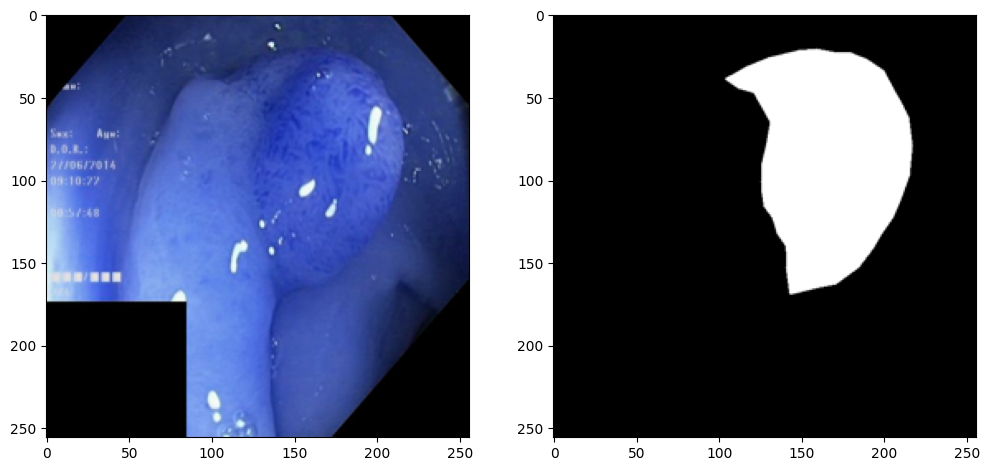

In [15]:
#Sanity check
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

Model Code

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom Residual Block
def residual_block(input_tensor, filters, kernel_size=(3, 3)):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the number of filters (channels) changes, add a 1x1 convolution to match the shapes
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)

    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

# Custom Recurrent Block
def recurrent_block(input_tensor, filters, kernel_size=(3, 3)):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the number of filters (channels) changes, add a 1x1 convolution to match the shapes
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)

    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='sigmoid')(x) # Sigmoid for gating mechanism
    x = layers.Multiply()([x, input_tensor])
    return x

# U-Net Model with Residual and Recurrent Blocks
def R2Unet(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Center
    conv5 = recurrent_block(pool4, 1024)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = residual_block(up6, 512)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = residual_block(up7, 256)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = residual_block(up8, 128)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = residual_block(up9, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Create the model

In [19]:
from keras.losses import binary_crossentropy

#input_shape = (256, 256, 3)  # Adjust the input shape based on your data
r2unet = R2Unet(input_shape)
r2unet.compile(optimizer=Adam(learning_rate), loss=dice_coef_loss, metrics=[dice_coef,dice_coef_loss,jacard_coef,jacard_coef_loss])
#att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy',jacard_coef])

print(r2unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Validation result

In [20]:
model_path = "/content/drive/MyDrive/r2unet.hdf5"

r2unet_model = tf.keras.models.load_model(model_path, compile=False)
r2unet_model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=[dice_coef, dice_coef_loss, jacard_coef, jacard_coef_loss])

r2unet_model.summary()

results = r2unet_model.evaluate(X_val, y_val, batch_size=8)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 256, 64  256        ['conv2d_2[0][0]']               
 rmalization)                   )                                                             

Learning rate

In [21]:
from tensorflow.keras.callbacks import LearningRateScheduler
epochs=100

def scheduler(epoch,learning_rate):
  if epoch <=45:
    return 0.001
  else:
    return 0.001


learning_rate =0.001
for i in range(epochs):
  lr = scheduler(i,learning_rate)
  print(i, learning_rate)

0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 0.001
12 0.001
13 0.001
14 0.001
15 0.001
16 0.001
17 0.001
18 0.001
19 0.001
20 0.001
21 0.001
22 0.001
23 0.001
24 0.001
25 0.001
26 0.001
27 0.001
28 0.001
29 0.001
30 0.001
31 0.001
32 0.001
33 0.001
34 0.001
35 0.001
36 0.001
37 0.001
38 0.001
39 0.001
40 0.001
41 0.001
42 0.001
43 0.001
44 0.001
45 0.001
46 0.001
47 0.001
48 0.001
49 0.001
50 0.001
51 0.001
52 0.001
53 0.001
54 0.001
55 0.001
56 0.001
57 0.001
58 0.001
59 0.001
60 0.001
61 0.001
62 0.001
63 0.001
64 0.001
65 0.001
66 0.001
67 0.001
68 0.001
69 0.001
70 0.001
71 0.001
72 0.001
73 0.001
74 0.001
75 0.001
76 0.001
77 0.001
78 0.001
79 0.001
80 0.001
81 0.001
82 0.001
83 0.001
84 0.001
85 0.001
86 0.001
87 0.001
88 0.001
89 0.001
90 0.001
91 0.001
92 0.001
93 0.001
94 0.001
95 0.001
96 0.001
97 0.001
98 0.001
99 0.001


Checkpoints and callbacks

In [22]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/r2unet-28jul-check.hdf5',
                                                 monitor='val_dice_coef_loss', \
                                                 verbose=1,
                                                 save_best_only=True)
lr_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
#early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_dice_coef')
#callbacks_list = [checkpointer,lr_rate, early_stoping]
callbacks_list = [checkpointer,lr_rate]

Model training

In [24]:
# Training

r2unet_history = r2unet.fit(X_train, y_train,
                    verbose=1,
                    batch_size = 8,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=100,
                    callbacks=callbacks_list,
                    )
# Save the model
r2unet.save('/content/drive/MyDrive/r2unet.hdf5')

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.5772 - dice_coef: 0.4215 - dice_coef_loss: 0.5785 - jacard_coef: 0.5434 - jacard_coef_loss: -0.5434
Epoch 1: val_dice_coef_loss improved from inf to 0.99965, saving model to /content/drive/MyDrive/r2unet-28jul-check.hdf5
113/113 [==============================] - 21s 150ms/step - loss: 0.5772 - dice_coef: 0.4215 - dice_coef_loss: 0.5785 - jacard_coef: 0.5434 - jacard_coef_loss: -0.5434 - val_loss: 0.9997 - val_dice_coef: 3.4972e-04 - val_dice_coef_loss: 0.9997 - val_jacard_coef: 3.4978e-04 - val_jacard_coef_loss: -3.4978e-04 - lr: 0.0010
Epoch 2/100
112/113 [============================>.] - ETA: 0s - loss: 0.5515 - dice_coef: 0.4485 - dice_coef_loss: 0.5515 - jacard_coef: 0.5898 - jacard_coef_loss: -0.5898
Epoch 2: val_dice_coef_loss improved from 0.99965 to 0.99189, saving model to /content/drive/MyDrive/r2unet-28jul-check.hdf5
113/113 [==============================] - 11s 94ms/step - loss: 0.5514 - dice_coef: 

Training history save

In [25]:
import pandas as pd
r2unet_history_df = pd.DataFrame(r2unet_history.history)

with open('/content/drive/MyDrive/r2unet_history_df_NEW.csv', mode='w') as f:
    r2unet_history_df.to_csv(f)

Validation and training plots

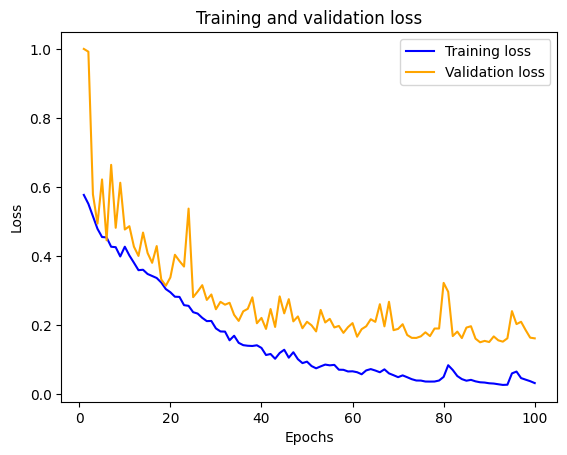

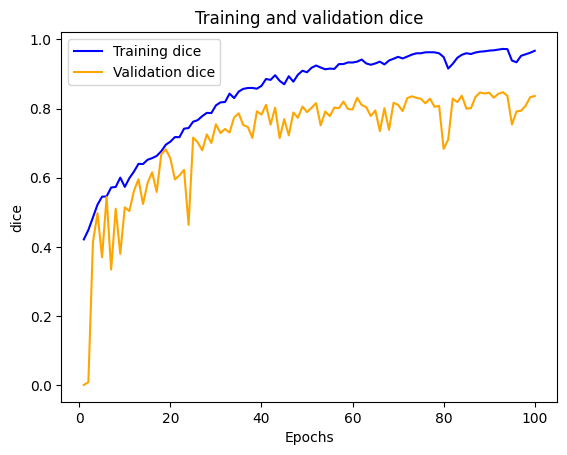

In [26]:
history = r2unet_history

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='blue', label='Training loss')
plt.plot(epochs, val_loss, color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, color='blue', label='Training dice')
plt.plot(epochs, val_dice, color='orange', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('dice')
plt.legend()
plt.show()


In [27]:
model = r2unet

Validation output

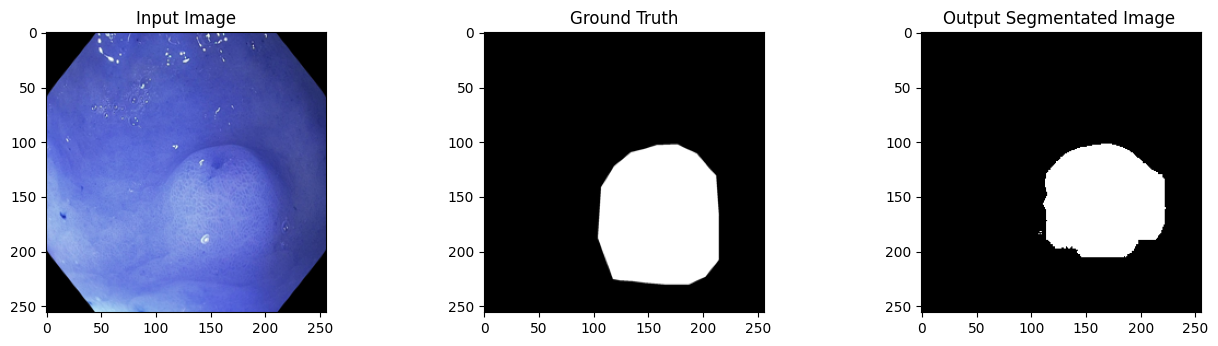

In [31]:
import random
val_img_number = random.randint(0, X_val.shape[0]-1)
val_img = X_val[val_img_number]
ground_truth=y_val[val_img_number]

val_img_input=np.expand_dims(val_img, 0)
prediction = (model.predict(val_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Input Image')
plt.imshow(val_img, cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Output Segmentated Image ')
plt.imshow(prediction, cmap='gray')
plt.show()

Validation evaluation

In [32]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
iou = IOU_keras.result().numpy()

y_true = ground_truth
y_pred = prediction


ground_truth = ground_truth.astype('float32')
prediction = prediction.astype('float32')

dice=dice_coef(ground_truth, prediction).numpy()

print("iou= ", iou)
print("dice= ",dice)

iou=  0.8167287
dice=  0.8226919


Test dataset

In [33]:
!unzip EndoTect_2020_Segmentation_Test_Dataset.zip

Archive:  EndoTect_2020_Segmentation_Test_Dataset.zip
   creating: EndoTect_2020_Segmentation_Test_Dataset/images/
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/003ab8b5-cf6d-442a-849d-80ddf0d1edaf.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/003f46f1-e447-486a-aeb7-6bf8b45a2184.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/00be7d4a-d643-4075-9ea3-e5bff2cd9a5c.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/00c7089c-caf9-4c1b-850f-bedbb11668fc.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/01deb8d0-4bc5-4092-9a76-9f5c2f74f0df.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/02ae2444-eddf-4fec-8b87-babc265d1553.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/02c9cc1e-349a-4689-bfb4-b7df1f44ca53.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/02d64f66-07e3-4e32-8ecd-5fec7e8acdba.jpg  
  inflating: EndoTect_2020_Segmentation_Test_Dataset/images/0

Load Test  dataset

In [34]:
import os
import cv2
import numpy as np
from PIL import Image

test_image_directory = 'EndoTect_2020_Segmentation_Test_Dataset/images'
test_mask_directory = 'EndoTect_2020_Segmentation_Test_Dataset/masks'

def load_test_dataset(test_image_directory, test_mask_directory):
    test_image_dataset = []
    test_mask_dataset = []

    test_images = os.listdir(test_image_directory)
    for i, image_name in enumerate(sorted(test_images)):
        if image_name.split('.')[1] == 'jpg':
            image_path = os.path.join(test_image_directory, image_name)
            image = cv2.imread(image_path, 1)
            if image is not None:
                image = Image.fromarray(image)
                image = image.resize((SIZE, SIZE))
                test_image_dataset.append(np.array(image))
            else:
                print(f"Error reading image: {image_path}")


    test_masks = os.listdir(test_mask_directory)
    for i, image_name in enumerate(sorted(test_masks)):
        if image_name.split('.')[1] == 'png':
            mask_path = os.path.join(test_mask_directory, image_name)
            image = cv2.imread(mask_path, 0)
            if image is not None:
                image = Image.fromarray(image)
                image = image.resize((SIZE, SIZE))
                test_mask_dataset.append(np.array(image))
            else:
                print(f"Error reading mask: {mask_path}")

    test_image_dataset = np.array(test_image_dataset) / 255.
    test_mask_dataset = np.expand_dims(np.array(test_mask_dataset), axis=-1) / 255.

    return test_image_dataset, test_mask_dataset

X_test, y_test = load_test_dataset(test_image_directory, test_mask_directory)

Print test image names

In [35]:
filenames = []
files = os.listdir(test_image_directory)
for i, image_name in enumerate(sorted(files)):
    if (image_name.split('.')[1] == 'jpg'):
      filenames.append(image_name)
      print(image_name)

003ab8b5-cf6d-442a-849d-80ddf0d1edaf.jpg
003f46f1-e447-486a-aeb7-6bf8b45a2184.jpg
00be7d4a-d643-4075-9ea3-e5bff2cd9a5c.jpg
00c7089c-caf9-4c1b-850f-bedbb11668fc.jpg
01deb8d0-4bc5-4092-9a76-9f5c2f74f0df.jpg
02ae2444-eddf-4fec-8b87-babc265d1553.jpg
02c9cc1e-349a-4689-bfb4-b7df1f44ca53.jpg
02d64f66-07e3-4e32-8ecd-5fec7e8acdba.jpg
02e05e0f-5335-4d25-b41b-8f3181fa8941.jpg
03a74938-0db3-4544-9a1a-e74121c47a9a.jpg
03b5d73c-d096-4d5c-af50-39c218425fcd.jpg
03b7f01a-8122-4cdf-8ddc-2b052f4b4099.jpg
03e15c74-4234-4074-bd5b-b4b81834d3d6.jpg
04c3a34e-a160-4421-827e-89671761ef82.jpg
05ae2939-4da1-41de-8bf8-0b225eba2d60.jpg
05f22ee2-e097-400c-8fcf-07a35e404bef.jpg
0a25da23-787f-47ce-877e-2934275b0801.jpg
0a2fd84b-e62b-4153-beab-75d7d8757f75.jpg
0a3f577c-5f57-452d-8ae2-c5e042079467.jpg
0a508419-ba4f-428c-9a30-43feb39c35c2.jpg
0a64434b-f2aa-4e8c-be2e-aaefeaea1951.jpg
0a64cf79-80be-436a-bb3d-978b586a4a4a.jpg
0a861d21-a718-426c-9003-d01ecd014dda.jpg
0a945e9c-17ec-4879-9c51-5601bae0aa3c.jpg
0ab286ad-3b4f-4c

Sanity check of testing dataset

Loaded 200 test images and 200 test masks.
48


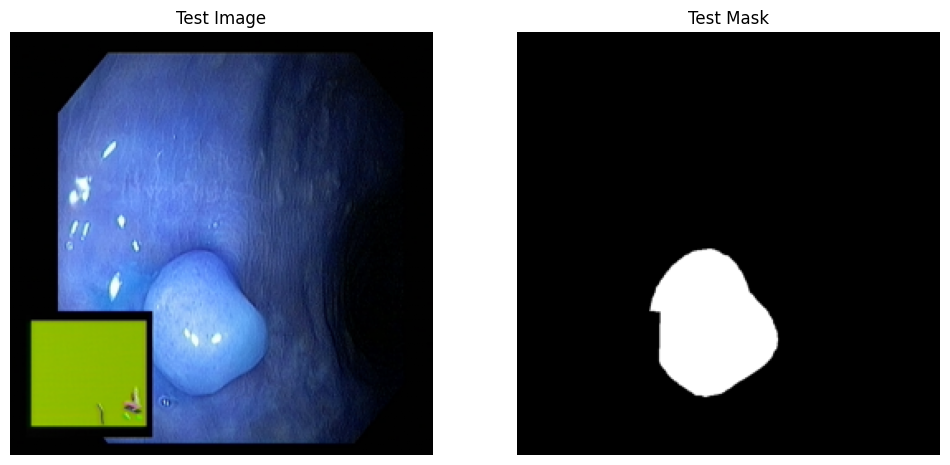

In [36]:
test_image_directory = 'EndoTect_2020_Segmentation_Test_Dataset/images'
test_mask_directory = 'EndoTect_2020_Segmentation_Test_Dataset/masks'


# Check if the test image and mask directories exist
if not os.path.exists(test_image_directory):
    print(f"Test image directory not found: {test_image_directory}")
elif not os.path.exists(test_mask_directory):
    print(f"Test mask directory not found: {test_mask_directory}")
else:
    # Load the test dataset
    X_test, y_test = load_test_dataset(test_image_directory, test_mask_directory)
    print(f"Loaded {len(X_test)} test images and {len(y_test)} test masks.")

    # Perform a sanity check by displaying a random image and its corresponding mask
    if len(X_test) > 0 and len(y_test) > 0:
        import random
        import matplotlib.pyplot as plt

        # Randomly select an image index from the test dataset
        image_number = random.randint(0, len(X_test) - 1)
        print(image_number)

        # Plot the randomly selected image and its corresponding mask
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(X_test[image_number])
        plt.title('Test Image')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(y_test[image_number].squeeze(), cmap='gray')
        plt.title('Test Mask')
        plt.axis('off')

        plt.show()


Testing output

6aeede7a-feab-4072-9e31-acf3a4edea9c.jpg


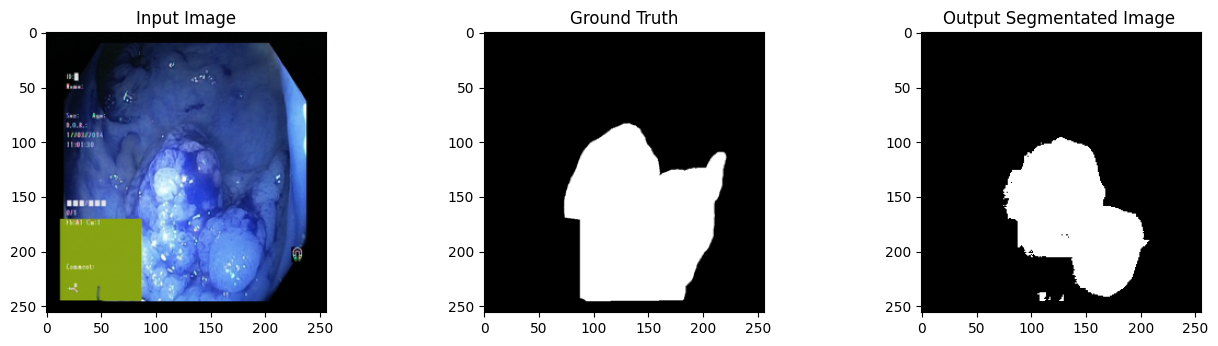

In [37]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
print(filenames[test_img_number])

test_img = X_test[test_img_number]
test_ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Input Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(test_ground_truth[:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Output Segmentated Image ')
plt.imshow(test_prediction, cmap='gray')
plt.show()

In [40]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_ground_truth[:, :, 0], test_prediction)
iou = IOU_keras.result().numpy()

test_ground_truth = test_ground_truth.astype('float32')
test_prediction = test_prediction.astype('float32')
dice=dice_coef(test_ground_truth, test_prediction).numpy()

print("Test Result")
print("iou= ", iou)
print("dice= ",dice)

Test Result
iou=  0.7020447
dice=  0.6937091


In [46]:
import pandas as pd

test_image_dataset = np.array(test_image_dataset)
test_mask_dataset = np.array(test_mask_dataset)

IoU_values = []
dice_values = []

for img in range(0, test_image_dataset.shape[0]):
    temp_img = test_image_dataset[img]
    test_ground_truth=test_mask_dataset[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    test_prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    print(filenames[img])

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Input Image')
    plt.imshow(temp_img, cmap='gray')

    plt.subplot(232)
    plt.title('Ground Truth')
    plt.imshow(test_ground_truth[:,:,0], cmap='gray')

    plt.subplot(233)
    plt.title('Output Segmented Image')
    plt.imshow(test_prediction, cmap='gray')

    plt.savefig('/content/drive/MyDrive/Segmented/{}'.format(filenames[img]), bbox_inches="tight", pad_inches=0.5)
    plt.show()

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(test_ground_truth[:, :, 0], test_prediction)
    iou = IoU.result().numpy()
    OoU_values.append(IoU)

    ground_truth1 = test_ground_truth.astype('float32')
    prediction1 = test_prediction.astype('float32')
    dice = dice_coef(ground_truth1, prediction1).numpy()

    ground_truth1 = test_ground_truth.astype('float32')
    prediction1 = test_prediction.astype('float32')
    dice = dice_coef(ground_truth1, prediction1).numpy()
    dice_values.append(dice)

    y_true = test_ground_truth
    y_pred = test_prediction

    print("iou= ", IoU)
    print("dice= ",dice)

with open('/content/drive/MyDrive/dicelistd52.txt', 'w') as fp:
    for item in dice_values:
      fp.write("%s\n" % item)
    print('Done dice txt')

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values

df2 = pd.DataFrame(dice_values, columns=["dice"])
df2 = df2[df2.dice != 1.0]
mean_dice = df2.mean().values

print("Mean IoU on unseen is: ", mean_IoU)
print("Mean dice on unseen is: ", mean_dice)

Done dice txt
Mean IoU on unseen is:  [nan]
Mean dice on unseen is:  [nan]
